# Assignment 3 Math Foundations Machine Learning
## David Alvear 187594

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

## 3. Automatic diferentiation. 

In [2]:
import torch
# Define variables
x1 = torch.tensor(0.0, requires_grad=True)
x2 = torch.tensor(2.0, requires_grad=True)

# Compute function
f = torch.exp(x1) * (x1 ** 2 + x2 ** 2) ** 3
f.backward()

# Get gradients
print(x1.grad)
print(x2.grad)

tensor(64.)
tensor(192.)


## 4. Stochastic Gradient.


[4 3 1 ... 5 5 5]


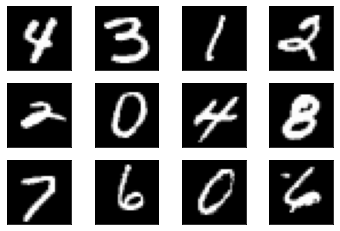

In [3]:
# read MNIST training data
df_train = pd.read_csv('../data/mnist_train.csv')
df_test = pd.read_csv("../data/mnist_test.csv")
df = pd.concat([df_train, df_test]).reset_index(drop=True).sample(frac=1).reset_index(drop=True)
data = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
labels = df.iloc[:, 0].to_numpy()                # labels of images
print(labels)

# plot the first dozen images from the data set
plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1, xticks=[], yticks=[])
    image = data[i, :].reshape((28,28))
    plt.imshow(image, cmap='gray')

In [5]:
# tensors
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)
labels_tensor = (labels_tensor == 5).float()

In [6]:
class TorchBinaryLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(TorchBinaryLogisticRegression, self).__init__()
        self.nn_layer = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.nn_layer(x))

dimension = data_tensor.shape[1]
model = TorchBinaryLogisticRegression(dimension)

In [7]:
# Compute manually the gradient loss using result of exercise 1
model.zero_grad()
pred_probs = model(data_tensor)
loss = -torch.mean(labels_tensor.squeeze() * torch.log(pred_probs.squeeze()) + (1 - labels_tensor.squeeze()) * torch.log(1 - pred_probs.squeeze()))
loss.backward()
manual_gradients = model.nn_layer.weight.grad.clone()
print("Gradient computed manually:", manual_gradients)

Gradient computed manually: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  3.3896e-06,  1.2756e-05,  5.9362e-06,
          2.4734e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  4.3475e-07,  2.6146e-06,  2.3744e-05,
          4.8349e-05,  8.7830e-05,  1.2536e-04,  2.3501e-04,  3.3978e-04,
          3.7704e-04,  3.7008e-04,  4.0304e-04,  3.5735e-04,  3.3637e-04,
          2.8341e-04,  1.8753e-04,  1.2166e-04,  8.4393e-05,  3.2430e-05,
          1.6131e-05,  6.1267e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.8136e-06,  1.1449e-06,
          1.0957e-05,  2.0597e-05,  1.0923e-04,  2.7503e-04,  5.2927e-04,
          

In [8]:
# now use the loss from pytorch
criterion_loss = nn.BCELoss()
model.zero_grad()
pred_probs = model(data_tensor)
bce_loss = criterion_loss(pred_probs.squeeze(), labels_tensor.squeeze())
bce_loss.backward() 
torch_gradient = model.nn_layer.weight.grad

# how different or far are they?
euclidean_distance = torch.norm(manual_gradients - torch_gradient).item()
mse = torch.mean((manual_gradients - torch_gradient)**2).item()

print(f"Euclidean Distance: {euclidean_distance}")
print(f"Mean Squared Error: {mse}")

Euclidean Distance: 1.174711243834281e-07
Mean Squared Error: 1.7601359533195387e-17


### Comments
Looking at the euclidean distance and the mean squared error between the manual and computed gradient we conclude that they are closer each other.

using a batch size of b = 32, write a function that returns a stochastic gradient of J by choosing b
randomly chosen images from the dataset.

In [14]:
def stochastic_gradient(data, labels, model, criterion, batch_size=32):
    # select a batch of data
    idx = torch.randint(0, data.size(0), (batch_size,))
    data_batch = data[idx]
    label_batch = labels[idx]

    # Reset gradients
    model.zero_grad()

    # Forward pass
    prob_predicted = model(data_batch)

    # Compute loss
    loss = criterion(prob_predicted.squeeze(), label_batch.squeeze())

    # Backward pass
    loss.backward()

    # Return the stochastic gradient
    return model.nn_layer.weight.grad

sgd = stochastic_gradient(data_tensor, labels_tensor, model, criterion_loss)
print(f"Stochastic gradient descent with batch_size=32 :{sgd}")

Stochastic gradient descent with batch_size=32 :tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  6.3789e-05,  5.1031e-03,  1.

call the stochastic gradient function a large number of times to obtain an estimate of its expected value. Compare with the full gradient.

In [17]:
# Initialize variable to store sum of stochastic gradients
stochastic_grad_sum = torch.zeros((dimension, 1))
num_iterations = 2000
stochastic_gradients = []
for _ in range(num_iterations):
    grad = stochastic_gradient(data_tensor, labels_tensor, model, criterion_loss)
    stochastic_gradients.append(grad)

average_stochastic_gradient = torch.stack(stochastic_gradients).mean(dim=0)

In [18]:
# Estimate the difference with the computed loss
# Compare the expected stochastic gradient with the full gradient
difference = torch.norm(average_stochastic_gradient - torch_gradient)

print(f"The difference between the expected stochastic gradient and the full gradient is: {difference.item()}")

The difference between the expected stochastic gradient and the full gradient is: 3.800286663135921e-07


After 2000 iterations we can have a really close estimate of the gradient using stochastic gradient descent with batch size of 32. The SGD was compared with the full gradient computation with the whole data tensor.